In [22]:
# Installing requirements
!pip3 install medpy
!pip3 install pywavefront
!pip3 install pickle5

In [44]:
# # Mount drive (uncomment this if you are using Google Colab)
# from google.colab import drive
# drive.mount('/content/drive/')
# %cd /content/drive/MyDrive/IC/python

# Reconstruction of curves by means of robust features

This project aims to represent discrete curves using a few anchor points. It extracts the points using a discrete curvature analysis and try to reconstruct it using differential coordinates as described in Sorkine (2006).

The steps of the project are organised by the following sections:

- Image reading and preprocessing
- Curvature analysis
- Important points extraction
- Curve reconstruction
- Tests and calculate distance (error)

<b>Developed by:</b> André Luís Mendes Fakhoury<br>
<b>Supervisor:</b> João Batista do Espírito Santo Neto<br>
<b>Support:</b> This project is supported by FAPESP no 2020/07224-5

In [24]:
from medpy.filter.smoothing import anisotropic_diffusion
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib import cm
import numpy as np
import pywavefront
import cv2 as cv
import imageio
import pickle5 as pickle
import os

%matplotlib inline

# Preprocessing

Here, we have to preprocess the image and return the coordinates of the boundaries of the main object present in the figure.

Preprocessing steps:
- Gaussian blur
- Convert to Grayscale
- Otsu thresholding
- Countour finding

In [25]:
# Preprocess image and return the contours
def get_contours(img_original):
    img_filter = cv.GaussianBlur(img_original, (5, 5), cv.BORDER_DEFAULT)

    img = cv.cvtColor(img_filter, cv.COLOR_BGR2GRAY)
    img = cv.bitwise_not(img)

    thr, edged = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    contours, hierarchy = cv.findContours(edged, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

    lens = [len(contours[i]) for i in range(len(contours))]
    contour_pos = np.where(lens == np.amax(lens))[0][0]

    image = np.copy(img_original)
    cv.drawContours(image, contours, contour_pos, (100, 255, 100), 3)
    
    return np.squeeze(contours[contour_pos]), edged

# Curve processing

With the coordinates (x, y) of each boundary point, we can consider the contour as a discrete curve. So, we can calculate the curvature on each point of this curve.

In [26]:
from scipy.fft import fft, ifft, fftshift, ifftshift

# Calculate discrete derivative of y(x), using a Gaussian with given sigma
def calc_derivative(y, x, sigma):
    n = x.shape[0]
    step = 1.0 / (x[-1] - x[0])
    x = np.arange(-n//2, n - n//2 - n%2) * step
    gauss = np.exp(-((np.square(x))/(np.square(sigma))) / 2)
    gauss = fftshift(gauss)
    
    y = fft(fftshift(y))
    A = gauss * y
    
    der = fftshift(2 * np.pi * 1j * x)
    return ifftshift(np.real(ifft(A * der)))

# Calculate the curvature on each point of coordinates x(t) and y(t) 
def calc_curvature(x, y, t):
    sigma = 10;
    dx = calc_derivative(x, t, sigma)
    dy = calc_derivative(y, t, sigma)
    
    d2x = calc_derivative(dx, t, sigma)
    d2y = calc_derivative(dy, t, sigma)
    
    return (dx * d2y - dy * d2x) / (np.square(dx) + np.square(dy))**(3/2)

## Choosing the best Anchor Points

Here we are looking for some points that well represent the whole curve. To do it, I'm currently choosing 25% of the points as linear spaced samples, and the rest of them are just taken according to the curvature - I try to take the points with the greatest absolute values (and also taking care to not choose points too close to each other).

In [27]:
# Choose anchor points according to curvature or linspace
def choose_anchor(contour, qtt, method='curvature'):
    n = len(contour)
    assert(qtt <= n)
    
    if method == 'curvature':
        kappa = calc_curvature(contour[:,0], contour[:,1], np.arange(n))
        arr = sorted([(np.abs(kappa[i]), i) for i in range(n)], reverse=True)
        chosen = set(np.linspace(0, n - 1, qtt//4).astype(int))

        delta_range = n // 20
        while len(chosen) < qtt:
            for curv, idx in arr:
                can_be = len(chosen) < qtt
                for delta in range(-delta_range, delta_range):
                    can_be = can_be and not (idx + delta) % n in chosen
                if can_be:
                    chosen.add(idx)
            delta_range = max(delta_range - 5, 0)
        return list(chosen)[:qtt]
    elif method == 'linspace':
        return np.linspace(0, n - 1, qtt).astype(int)
    else:
        raise "Invalid method"

# Reconstruction

Here we apply the reconstruction method based on the discrete Laplacian Operator as described in [Sorkine (2006)](https://igl.ethz.ch/projects/Laplacian-mesh-processing/STAR/CGF-Laplacian-mesh-processing.pdf).

In [28]:
import numpy as np

# generate default adjacency (i is connected to i-1 and i+1).
# If closed=True, connects 0 and n-1.
def gen_default_adjacency(n, closed=True):
    A = np.zeros((n, n))
    r = np.arange(n)
    A[r-1,r] = 1
    A[r,r-1] = 1
    if not closed:
        A[0, -1] = 0
        A[-1, 0] = 0
    return A

# Generate default weights of differential coordinates.
def gen_default_weights(A):
    c = sum(A)
    w = A / c
    return w, c

# Generate delta coordinates according to v, w and c
def gen_delta_coords(v, w, c):
    n, x = v.shape
    delta = np.zeros((n, x))
    for i in range(n):
        delta[i] = - sum((w[i] * (v - v[i]).T).T) * c[i]
    return delta

# generate simmetric Laplacian matrix
def gen_laplacian(A):
    return np.diag(sum(A)) - A

# Recover absolute cartesian coordinates from delta coordinates
def recover_coords(L, delta, anchor_id, anchor_val):
    n = L.shape[0]
    k, ndims = anchor_val.shape
    
    add_L = np.zeros((k, n))
    add_L[np.arange(k),anchor_id] = 1
    L = np.concatenate((L, add_L), axis=0)
    
    delta = np.concatenate((delta, anchor_val), axis=0)
    v = np.zeros((n, ndims))
    for i in range(ndims):
        v[:,i] = np.linalg.linalg.lstsq(L, delta[:,i].T, rcond=None)[0].T
    return v

# Generate default info and reconstruct values
def gen_and_recover(n, anchor_id, anchor_val, closed=True):
    n_dims = anchor_val[0].shape[0]
    A = gen_default_adjacency(n, closed)
    w, c = gen_default_weights(A)
    L = gen_laplacian(A)
    delta = np.zeros((n, n_dims)).astype(np.float64)
    return recover_coords(L, delta, anchor_id, anchor_val)

# Tests

With every auxiliary methods done, we can finnaly test and calculate the error. 

Error is defined as the sum of Euclidean distances between the original and reconstructed points.

In [29]:
# returns the error (Euclidean distance) of reconstruction
def get_error(original, reconstructed):
    return np.linalg.norm(original - reconstructed)

In [30]:
# test an image using the methods above defined
def test_image(img_file, anchor_qtt=50, debug_print=True, show_plot=True):
    if debug_print:
        print(f'Processing image {img_file}... ', end='', flush=True)
    
    img_original = imageio.imread(img_file)
    contour, edged = get_contours(img_original)

    n, ndims = contour.shape
    if debug_print:
        print(f'{n} points ', end='', flush=True)

    anchor = choose_anchor(contour, anchor_qtt, method='curvature')
    
    if debug_print:
        print('[anchors ok] ', end='', flush=True)
    
    v_rec = gen_and_recover(n, anchor, contour[anchor])
    
    error = get_error(contour, v_rec)
    if debug_print:
        print('[ok] [error = %.6f]' % error, flush=True)
    
    # show images
    if show_plot:
        plt.figure(figsize=(20, 6))
        plt.subplot(151)
        plt.imshow(img_original)
        plt.subplot(152)
        plt.imshow(edged)
        plt.subplot(153)
        plt.plot(v_rec[:,0], v_rec[:,1], color=(47/255, 153/255, 82/255))    
        ax = plt.gca()
        ax.set_ylim(ax.get_ylim()[::-1])
        plt.subplot(154)
        plt.scatter(contour[anchor,0], contour[anchor,1], color=(1.0, 0.0, 0.0), marker='*')    
        ax = plt.gca()
        ax.set_ylim(ax.get_ylim()[::-1])
        plt.subplot(155)
        plt.plot(contour[:,0], contour[:,1], color=(0.0, 0.0, 1.0))
        plt.plot(v_rec[:,0], v_rec[:,1], color=(60/255, 153/255, 82/255))
        plt.scatter(contour[anchor,0], contour[anchor,1], color=(1.0, 0.0, 0.0), marker='*')
        ax = plt.gca()
        ax.set_ylim(ax.get_ylim()[::-1])
        plt.show()
    return contour, anchor, v_rec

## Test with leaves images

Testing with images from ImageCLEF (2011).

Processing image img/15.jpg... 2863 points [anchors ok] [ok] [error = 419.148232]


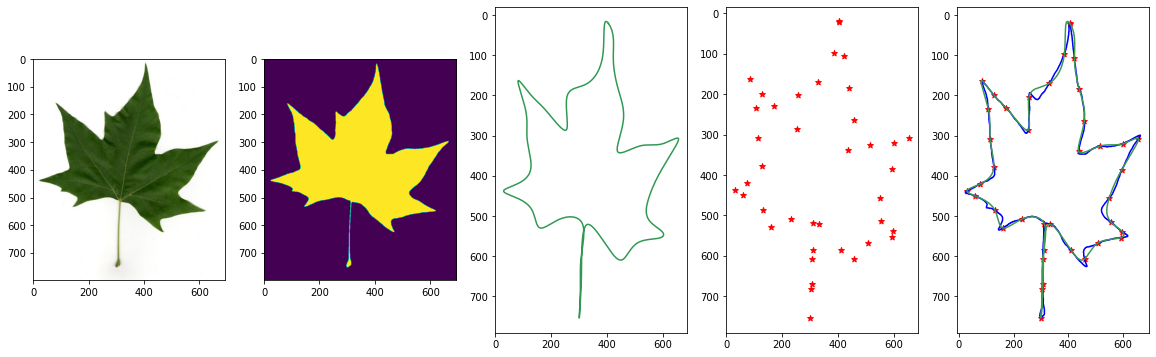

In [31]:
contour, anchor, v_rec = test_image('img/15.jpg', 40)

### Batch test

Testing a lot of images from ImageCLEF repository.

In [32]:
# check if pickle doesn't exists and generate results (take some time to process)
if not os.path.exists('leaf_results.pickle'):
    batch_results = dict()
    for img_dir in tqdm(sorted(os.listdir('img'))):
        batch_results[img_dir] = test_image(f'img/{img_dir}', debug_print=False, show_plot=False)

    # save results to pickle file
    with open('leaf_results.pickle', 'wb') as f:
        pickle.dump(batch_results, f, pickle.HIGHEST_PROTOCOL)

In [33]:
# recover map from pickle and plot
with open('leaf_results.pickle', 'rb') as f:
    batch_results = pickle.load(f)
    for k, v in batch_results.items():
        fname, contour, anchor, recovered = k, *v

        # plot current graph
        plt.figure(figsize=(20, 6))
        plt.subplot(131)
        plt.imshow(cv.imread(f"img/{fname}"))
        plt.subplot(132)
        plt.plot(contour[:,0], contour[:,1], color=(47/255, 153/255, 82/255))    
        ax = plt.gca()
        ax.set_ylim(ax.get_ylim()[::-1])
        plt.title(f'{fname} - Error: %.5f' % get_error(contour, recovered))
        plt.subplot(133)
        plt.plot(recovered[:,0], recovered[:,1], color=(60/255, 153/255, 82/255))
        plt.scatter(contour[anchor,0], contour[anchor,1], color=(1.0, 0.0, 0.0), marker='*')
        ax = plt.gca()
        ax.set_ylim(ax.get_ylim()[::-1])
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Tests with custom examples

Okay, we tested everything with leaves, and some of them get better results than the other ones: but it actually doesn't matter, as we want to make the best possible result to faces - and some features observed on leaves are not present on faces. So here I'm trying some other tests, using other curves.

## 2D parametric curves

Text(0.5, 1.0, 'Reconstructed')

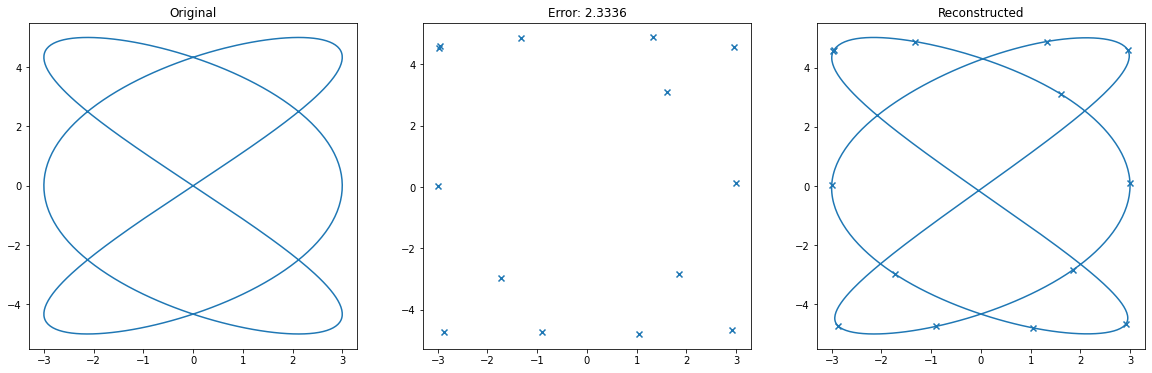

In [34]:
n = 700
t = np.linspace(1, 2.315 * np.pi, n)

# parametric function
x, y = 3 * np.cos(3 * t), 5 * np.sin(2 * t)

v = np.stack((x, y), axis=-1)

# get anchors and reconstruct
anchor = choose_anchor(v, n//50, 'curvature')
v_rec = gen_and_recover(n, anchor, v[anchor], closed=True)

# plot graphs
plt.figure(figsize=(20, 6))
plt.subplot(131)
plt.plot(v[:,0], v[:,1])
plt.title('Original')
plt.subplot(132)
plt.scatter(v[anchor,0], v[anchor,1], marker='x')
plt.title('Error: %.4f' % get_error(v, v_rec))
plt.subplot(133)
plt.plot(v_rec[:,0], v_rec[:,1])
plt.scatter(v[anchor,0], v[anchor,1], marker='x')
plt.title('Reconstructed')

## Open curves

The Sorkine's algorithm should work with open curves as well, if given the correct adjacency matrix. Here we can confirm it.

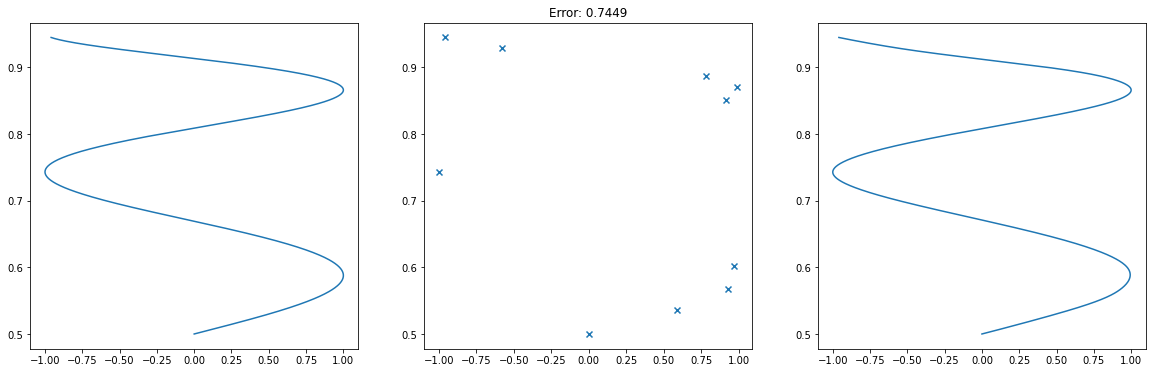

In [35]:
n = 1000
t = np.linspace(1, np.pi, n)

# parametric function (x(t), y(t)) = (sin(5t), cos(t/3))
x, y = np.sin(5 * t), np.cos(t/3)

v = np.stack((x, y), axis=-1)

anchor = choose_anchor(v, 10, 'curvature')
v_rec = gen_and_recover(n, anchor, v[anchor], closed=False)

# plot graphs
plt.figure(figsize=(20, 6))
plt.subplot(131)
plt.plot(v[:,0], v[:,1])
plt.subplot(132)
plt.scatter(v[anchor,0], v[anchor,1], marker='x')
plt.title('Error: %.4f' % get_error(v, v_rec))
plt.subplot(133)
plt.plot(v_rec[:,0], v_rec[:,1])

## 3D curves

The functions here developed should also work well with any any mesh, including 3D curves.

Error: 0.6685389743989818


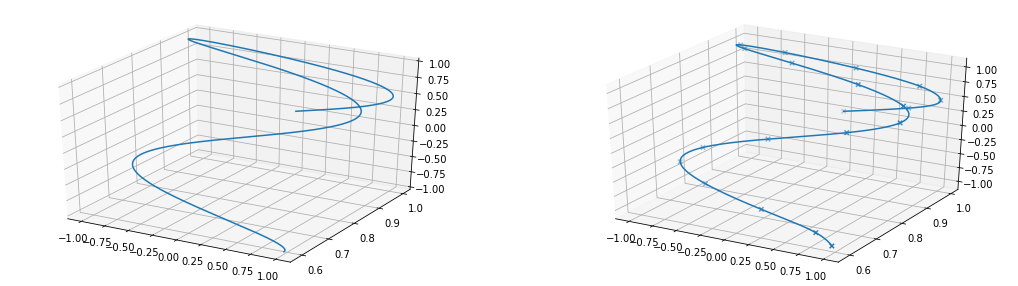

In [36]:
n = 1000
t = np.linspace(0, 1.5 * np.pi, n)

# parametric function (x(t), y(t), z(t)) = (sin(3t), cos(t/5), sin(t))
x, y, z = np.sin(3 * t), np.cos(t / 5), np.sin(t)

anchor = choose_anchor(v, 20, method='linspace')

v = np.stack((x, y, z), axis=-1)
v_rec = gen_and_recover(n, anchor, v[anchor], closed=False)

# plot graphs
plt.figure(figsize=(18, 5))
ax = plt.subplot(121, projection='3d')
ax.plot(v[:,0], v[:,1], v[:,2])
ax = plt.subplot(122, projection='3d')
ax.plot(v_rec[:,0], v_rec[:,1], v_rec[:,2])
ax.scatter(v[anchor,0], v[anchor,1], v[anchor,2], marker='x')

print('Error:', get_error(v, v_rec))

## 3D Meshes

Testing the algorithm with some meshes.

In [43]:
# given an obj, return the number of vertices, array of positions v, faces and adjacency matrix
def get_graph_from_mesh(obj):
    v = np.array(obj.vertices)

    n = len(v)
    A = np.zeros((n, n))

    faces = np.concatenate([f.faces for f in obj.mesh_list])
    A[faces[:,0], faces[:,1]] = A[faces[:,1], faces[:,0]] = 1
    A[faces[:,0], faces[:,2]] = A[faces[:,2], faces[:,0]] = 1
    A[faces[:,1], faces[:,2]] = A[faces[:,2], faces[:,1]] = 1
    return n, v, faces, A

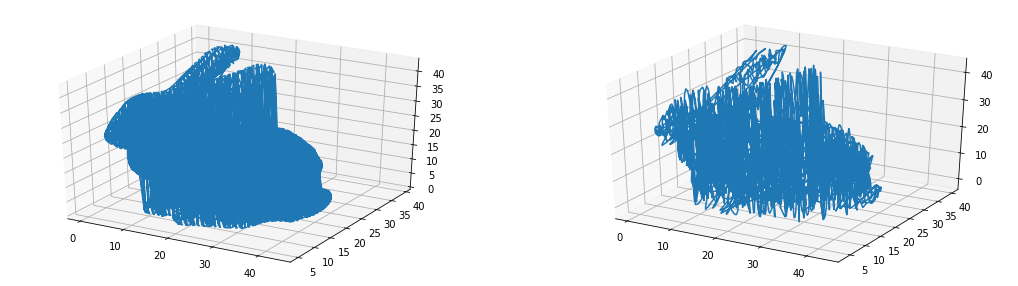

In [38]:
# read obj from file
obj = pywavefront.Wavefront('obj/bunny.obj', collect_faces=True)
n, v, faces, A = get_graph_from_mesh(obj)

anchor = choose_anchor(v, int(0.3 * n), method='linspace')
v_rec = gen_and_recover(n, anchor, v[anchor], closed=False)

# plot meshes
plt.figure(figsize=(18, 5))
plt.subplot(121, projection='3d')
ax = plt.plot(v[:,0], v[:,1], v[:,2])

plt.subplot(122, projection='3d')
plt.plot(v_rec[:,0], v_rec[:,1], v_rec[:,2])

In [42]:
# Print vertices and faces in wavefront (triangle mesh) file (ignoring normal and texture vectors)
def save_obj_simplified(vertices, faces, filename):
    with open(filename, 'w') as f:
        for v in vertices:
            f.write(f'v %.4f %.4f %.4f\n' % (v[0], v[1], v[2]))
        for c in faces:
            f.write(f'f %d// %d// %d//\n' % (c[0] + 1, c[1] + 1, c[2] + 1))

if 'faces' in locals():
    save_obj_simplified(v_rec, faces, 'obj/bunny_rec.obj')